In [19]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# This will automatically reload src/dtree.py every time you make changes and save the file
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
%matplotlib inline

In [21]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [22]:
# combine
# fill in make
# fill in mileage, age
# fill in power and engine cap
# fill in policy-related values except depreciation rate
# calculate price based on depreciation rate
# save the values with price and evaluate the performance

In [23]:
df1 = pd.read_csv('./train.csv')
df2 = pd.read_csv('./test.csv')
l = df2.columns.tolist()
df1 = df1[l]
df = pd.concat([df1, df2])
trainLen = len(df1)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21784 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         21784 non-null  int64  
 1   title              21784 non-null  object 
 2   make               18997 non-null  object 
 3   model              21784 non-null  object 
 4   description        21328 non-null  object 
 5   manufactured       21529 non-null  float64
 6   original_reg_date  418 non-null    object 
 7   reg_date           21522 non-null  object 
 8   type_of_vehicle    21784 non-null  object 
 9   category           21784 non-null  object 
 10  transmission       21784 non-null  object 
 11  curb_weight        21049 non-null  float64
 12  power              18772 non-null  float64
 13  fuel_type          4541 non-null   object 
 14  engine_cap         21716 non-null  float64
 15  no_of_owners       21552 non-null  float64
 16  depreciation       2121

df_valid = df.dropna(subset = ['fuel_type'])

missingfuel_type = df.fuel_type.isnull()
dfm = df[missingfuel_type]
missingModelAge = []
for idx, row in dfm.iterrows():
    model = row['model']
    missingModelAge.append(model)

mapper = {}
for idx, row in df_valid.iterrows():
    model = row['model']
    fuel_type = row['fuel_type']
    mapper[model] = fuel_type

for idx, row in dfm.iterrows():
    model = row['model']
    if model in mapper:
        df.at[idx, 'fuel_type'] = mapper[model]

print(df['fuel_type'].isnull().sum())

In [25]:
#fill in make
dfvalid = df.dropna(subset = ['make'])

missingMake = df.make.isnull()
dfm = df[missingMake]
missingModelAge = []
for idx, row in dfm.iterrows():
    model = row['model']
    missingModelAge.append(model)

mapper = {}
for idx, row in dfvalid.iterrows():
    model = row['model']
    make = row['make']
    mapper[model] = make

for idx, row in dfm.iterrows():
    model = row['model']
    df.at[idx, 'make'] = mapper[model]

print(df['make'].isnull().sum())

0


In [26]:
# fill in no_of_owners
df_valid = df.dropna(subset = ['mileage', 'no_of_owners'])
no_of_ownerss = df_valid['no_of_owners'].to_numpy()
caps = df_valid['mileage'].to_numpy()

k = 100
for idx, row in df.iterrows():
    if idx % 10000 == 0:
        print(idx)

    p, e = row['no_of_owners'], row['mileage']
    
    if type(row["mileage"]) == float and pd.isna(row["mileage"]):

        diff = np.abs(no_of_ownerss - p)

        indices = np.argsort(diff)[:k]

        k_caps = caps[indices]

        avg = np.average(k_caps)

        # Set the weight value of the current row to the median
        df.at[idx, 'mileage'] = avg
print(df['mileage'].isnull().sum())

0
10000
0
0


In [27]:
# get age and remaining coe
d1 = df['manufactured'].isnull()
df['age'] = df['manufactured'].copy()
df['age'][d1] = df['manufactured'][d1]
d1 = df['age'].isnull()
df['age'][d1] = df['reg_date'][d1]
d1 = df['age'].isnull()
df['age'][d1] = df['original_reg_date'][d1]
def month(x):
    if pd.isna(x):
        return np.nan
    mapper = {}
    all_m = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    for i in range(12):
        mapper[all_m[i]] = i + 1
    if len(str(x)) < 11:
        return (2021 - int(x)) * 12
    s = x.split('-')
    year = 2021 - int(s[-1])
    month = mapper[s[-2]]
    return year * 12 + month

def filterNeg(x):
    if x < 0:
        return 0
    return x
    
df['age'] = df['age'].map(month)

d1 = df['reg_date'].isnull()
df['remaining_coe'] = df['reg_date'].copy()
df['remaining_coe'][d1] = df['reg_date'][d1]
d1 = df['remaining_coe'].isnull()
df['remaining_coe'][d1] = df['original_reg_date'][d1]
d1 = df['remaining_coe'].isnull()
df['remaining_coe'][d1] = df['manufactured'][d1]
df['remaining_coe'] = 120 - df['remaining_coe'].map(month)
df['remaining_coe'] = df['remaining_coe'].map(filterNeg)

hasLifeSpan = ~df['lifespan'].isnull()
def get_remaining(x):
    diffFrom2021 = month(x)
    res = -diffFrom2021
    if res < 0:
        res = 0
    return res ##check 2021
df['remaining_coe'][hasLifeSpan] = df['lifespan'][hasLifeSpan].map(get_remaining)


G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
G:\softwares\envs\4277lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
G

In [28]:
# get omv
from collections import defaultdict
df_valid = df.dropna(subset = ['omv'])
# df_valid = pd.concat([df_valid, df_train], axis = 0)
# print(df_valid.shape)
omvs = df_valid['omv'].to_numpy()


# missingOmvModelsAge (1 year)
# missingomv = avg(modelAgeToSimilarOmv)
missingOmv = df.omv.isnull()
dfm = df[missingOmv]
missingModelAge = []
for idx, row in dfm.iterrows():
    model = row['model']
    age = row['age']
    p = (model, age)
    missingModelAge.append(p)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    age = row['age']
    omv = row['omv']
    p = (model, age)
    mapper[p].append(omv)

for idx, row in dfm.iterrows():
    model = row['model']
    age = row['age']
    p = (model, age)
    df.at[idx, 'omv'] = np.average(mapper[p])

G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning:

In [30]:
missingOmv = df.omv.isnull()
# print(df[missingOmv]['category'].unique())
# print(df[missingOmv][df.category.str.contains('low mileage')])
# print(df[missingOmv][df.age < 120]['category'])
print(df[missingOmv])

      listing_id                                        title           make  \
706      1012570                        Mitsubishi Rosa BE641     mitsubishi   
1026     1027950                   Honda Fit 1.3A G F-Package          honda   
1066      948629        Mercedes-Benz 280S (COE till 04/2025)         toyota   
1379      708763               Austin Prin (COE till 07/2030)         austin   
1586     1015500               Morris Mini (COE till 04/2029)         morris   
...          ...                                          ...            ...   
2708      996045          Toyota Estima 2.4A Aeras G Moonroof         toyota   
3224      970068         Mercedes-Benz 200 (COE till 12/2030)  mercedes-benz   
3647      973238      Toyota Hiace Commuter 3.0A GL High Roof         toyota   
4320     1027755                           Honda Vezel 1.5A X          honda   
4568     1027162  Mercedes-Benz GLE-Class GLE400 Coupe 4MATIC  mercedes-benz   

       model                           

In [37]:
# get omv
from collections import defaultdict
df_valid = df.dropna(subset = ['omv'])
# df_valid = pd.concat([df_valid, df_train], axis = 0)
# print(df_valid.shape)
omvs = df_valid['omv'].to_numpy()


# missingOmvModelsAge (1 year)
# missingomv = avg(modelAgeToSimilarOmv)
missingOmv = df.omv.isnull()
dfm = df[missingOmv]
missingModelAge = []
for idx, row in dfm.iterrows():
    model = row['model']
    age = row['age'] // 24 * 24
    p = (model, age)
    missingModelAge.append(p)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    age = row['age'] // 24 * 24
    omv = row['omv']
    p = (model, age)
    mapper[p].append(omv)

for idx, row in dfm.iterrows():
    model = row['model']
    age = row['age'] // 24 * 24
    p = (model, age)
    df.at[idx, 'omv'] = np.average(mapper[p])

48
44


G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning:

In [42]:
df_ = df.copy()
# df_ = df_[:trainLen]
# print(df_[df_.omv.isnull()])
print(len(df_[df_.omv.isnull()]))
# print(len(df_[:trainLen]))
# print(len(df_[trainLen:]))
print(trainLen)

37
16783


In [44]:
train = df[:16784].dropna(subset=['omv'])
test = df[16784:].copy()
df = pd.concat([train, test])

In [45]:
print(test[test.omv.isnull()])

      listing_id                                              title  \
706       861845               Lotus Super Seven (COE till 03/2028)   
1026      974600                    Morris Minor (COE till 06/2030)   
1770      943314          Alfa Romeo Spider 2000 (COE till 07/2030)   
1889      772738              Mercedes-Benz 250S (COE till 04/2029)   
1904     1007657  Jaguar E-Type Series 1 Roadster 3.8M (COE till...   
2062     1018356          Volkswagen Beetle 1200 (COE till 03/2030)   
2282      786155                  Mercedes-Benz 200 (New 10-yr COE)   
2633      982455                       Fiat 500C (COE till 06/2030)   
3224      970068               Mercedes-Benz 200 (COE till 12/2030)   

               make   model  \
706           lotus   super   
1026          honda   minor   
1770  mercedes-benz  spider   
1889  mercedes-benz     250   
1904         jaguar  e-type   
2062     volkswagen  beetle   
2282        hyundai     200   
2633           fiat     500   
3224  merc

In [46]:
# get omv
from collections import defaultdict
df_valid = df.dropna(subset = ['omv'])
# df_valid = pd.concat([df_valid, df_train], axis = 0)
# print(df_valid.shape)
omvs = df_valid['omv'].to_numpy()


# missingOmvModelsAge (1 year)
# missingomv = avg(modelAgeToSimilarOmv)
missingOmv = df.omv.isnull()
dfm = df[missingOmv]
missingModelAge = []
for idx, row in dfm.iterrows():
    model = row['model']
    age = row['age'] // 120 * 120
    p = (model, age)
    missingModelAge.append(p)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    age = row['age'] // 120 * 120
    omv = row['omv']
    p = (model, age)
    mapper[p].append(omv)

for idx, row in dfm.iterrows():
    model = row['model']
    age = row['age'] // 120 * 120
    p = (model, age)
    df.at[idx, 'omv'] = np.average(mapper[p])

print(df[df.omv.isnull()])
print(len(df[df.omv.isnull()]))

      listing_id                                              title  \
706       861845               Lotus Super Seven (COE till 03/2028)   
1026      974600                    Morris Minor (COE till 06/2030)   
1770      943314          Alfa Romeo Spider 2000 (COE till 07/2030)   
1889      772738              Mercedes-Benz 250S (COE till 04/2029)   
1904     1007657  Jaguar E-Type Series 1 Roadster 3.8M (COE till...   
2633      982455                       Fiat 500C (COE till 06/2030)   

               make   model  \
706           lotus   super   
1026          honda   minor   
1770  mercedes-benz  spider   
1889  mercedes-benz     250   
1904         jaguar  e-type   
2633           fiat     500   

                                            description  manufactured  \
706   only lotus s4 unit in the market! original sin...        1972.0   
1026  new paintwork with choice of colour. newly don...        1957.0   
1770  type 2 model, known as "kamm tail". the car ca...        19

G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning:

In [49]:
# prices = [120000, 33800, 109888, 718000, 718000, 109888]
df = df.dropna(subset = ['omv'])

In [156]:
# df_valid = df.dropna(subset = ['omv'])
# df_valid = pd.concat([df_valid, df_train], axis = 0)
# df.at[706, 'omv'] = np.average(df_valid[df_valid.age > 500]['omv'])

Empty DataFrame
Columns: [listing_id, title, make, model, description, manufactured, original_reg_date, reg_date, type_of_vehicle, category, transmission, curb_weight, power, fuel_type, engine_cap, no_of_owners, depreciation, coe, road_tax, dereg_value, mileage, omv, arf, opc_scheme, lifespan, eco_category, features, accessories, indicative_price, age, remaining_coe]
Index: []

[0 rows x 31 columns]


In [143]:
# vintage = df_train[df_train.age > 120].dropna(subset=['omv'])

In [144]:
## estimated omv
from sklearn.linear_model import LinearRegression
df_ = vintage.copy()
price = np.array(df_['price']).reshape(-1, 1)

age = np.array(df_['age']).reshape(-1, 1)

mileage = np.array(df_['mileage']).reshape(-1, 1)

X = np.concatenate((price, mileage, age), axis=1)
y = np.array(df_['omv']).reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_)


0.6159344005524925
[[ 4.08490354e-01 -5.88514510e-02 -8.17139997e+01]]


In [145]:
missingPriceAges = []
missingVintage = df[df.omv.isnull()][df.age >= 120]
idxs = missingVintage.index
# print(len(missingVintage))
for idx, row in missingVintage.iterrows():
    price = row['price']
    mileage = row['mileage']
    age = row['age']
    missingPriceAges.append((price, mileage, age))
# print(len(missingPriceAges))
omvs = reg.predict(np.array(missingPriceAges))
count = 0
for i in idxs:
    df.at[i, 'omv'] = omvs[count]
    count += 1
print(df['omv'].isnull().sum())

G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


KeyError: 'price'

In [113]:
# get the omv through regressor
df_ = df[df.category.str.contains('low mileage')][df.price > 250000].copy()
df_ = df_.dropna(subset=['omv'])
price = np.array(df_['price']).reshape(-1, 1)

age = np.array(df_['age']).reshape(-1, 1)

mileage = np.array(df_['mileage']).reshape(-1, 1)

X = np.concatenate((price, mileage, age), axis=1)
y = np.array(df_['omv']).reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_)

0.5917591109482048
[[0.28842062 1.96206857 8.78531653]]


G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [114]:
missingPriceAges = []
missing = df[df.omv.isnull()]
idxs = missing.index

for idx, row in missing.iterrows():
    price = row['price']
    mileage = row['mileage']
    age = row['age']
    missingPriceAges.append((price, mileage, age))
# print(len(missingPriceAges))
omvs = reg.predict(np.array(missingPriceAges))
count = 0
for i in idxs:
    df.at[i, 'omv'] = omvs[count]
    count += 1
print(df['omv'].isnull().sum())

0


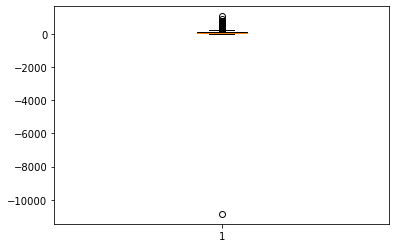

In [50]:
## age outlier
plt.boxplot(df['age'])
plt.show()

In [51]:
print(df[df.age > 20000])
print(df[df.age < 0])

Empty DataFrame
Columns: [listing_id, title, make, model, description, manufactured, original_reg_date, reg_date, type_of_vehicle, category, transmission, curb_weight, power, fuel_type, engine_cap, no_of_owners, depreciation, coe, road_tax, dereg_value, mileage, omv, arf, opc_scheme, lifespan, eco_category, features, accessories, indicative_price, age, remaining_coe]
Index: []

[0 rows x 31 columns]
      listing_id                                              title  \
6300      976150  Mercedes-Benz G-Class G350d AMG Line 4MATIC Pr...   

               make model                                        description  \
6300  mercedes-benz   amg  5 years warranty or 130,000km. call our friend...   

      manufactured original_reg_date     reg_date type_of_vehicle  \
6300        2925.0               NaN  03-mar-2021             suv   

                                               category  ...       omv  \
6300  parf car, almost new car, premium ad car, low ...  ...  109673.0   

     

In [52]:
# age,power, enginecap
df['age'][df.age < 0] = 0
df['age'][df.age > 20000] = 0

G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
##train
print(df[df.engine_cap == 0])
df.at[8199, 'engine_cap'] = np.nan

      listing_id                                              title  \
8199     1005670  Mercedes-Benz E-Class E300e Plug-in Hybrid AMG...   

               make model                                        description  \
8199  mercedes-benz   amg  great deal! grab it! new facelifted 2021 with ...   

      manufactured original_reg_date     reg_date type_of_vehicle  \
8199        2021.0               NaN  16-jun-2021    luxury sedan   

                                               category  ...      omv  \
8199  parf car, almost new car, low mileage car, hyb...  ...  52492.0   

          arf  opc_scheme lifespan   eco_category  \
8199  66486.0         NaN      NaN  uncategorized   

                                               features  \
8199  2.0l m274 powerplant with eq boost producing 3...   

                                            accessories  indicative_price  \
8199  amg kits and wheels, memory seat, ambient ligh...               NaN   

      age  remaining_coe  
81

{'whiskers': [<matplotlib.lines.Line2D at 0x253de1d6a88>,
 'caps': [<matplotlib.lines.Line2D at 0x253dd1212c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x253dd121688>],
 'medians': [<matplotlib.lines.Line2D at 0x253dce7a088>],
 'fliers': [<matplotlib.lines.Line2D at 0x253dd234688>],
 'means': []}

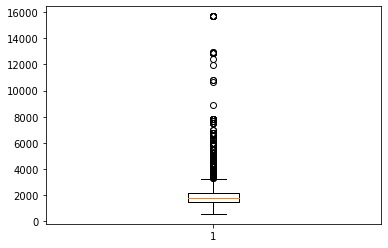

In [159]:
plt.boxplot(df['engine_cap'].dropna())

In [56]:
df_valid = df.dropna(subset = ['power'])
ps = df_valid['power'].to_numpy()

missingPs = df.power.isnull()
dfm = df[missingPs]
missingPower = []
for idx, row in dfm.iterrows():
    model = row['model']
    missingPower.append(model)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    power = row['power']
    mapper[model].append(power)

for idx, row in dfm.iterrows():
    model = row['model']
    if len(mapper[model]):
        df.at[idx, 'power'] = np.average(mapper[model])

print(df['power'].isnull().sum())

82


In [57]:
df_valid = df.dropna(subset = ['engine_cap'])
ps = df_valid['engine_cap'].to_numpy()

missingPs = df.power.isnull()
dfm = df[missingPs]
missingPower = []
for idx, row in dfm.iterrows():
    model = row['model']
    missingPower.append(model)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    power = row['engine_cap']
    mapper[model].append(power)

for idx, row in dfm.iterrows():
    model = row['model']
    if len(mapper[model]):
        df.at[idx, 'engine_cap'] = np.average(mapper[model])

print(df['engine_cap'].isnull().sum())

69


In [58]:
df_valid = df.dropna(subset = ['power', 'engine_cap'])
powers = df_valid['power'].to_numpy()
caps = df_valid['engine_cap'].to_numpy()

k = 10

# Loop over each data point in our dataset
for idx, row in df.iterrows():
    p, e = row['power'], row['engine_cap']
    
    if type(row["power"]) == float and pd.isna(row["power"]):
        diff = np.abs(caps - e)

        indices = np.argsort(diff)[:k]

        k_powers = powers[indices]

        avg = np.average(k_powers)

        # Set the weight value of the current row to the median
        df.at[idx, 'power'] = avg

In [59]:
df_valid = df.dropna(subset = ['power', 'engine_cap'])
powers = df_valid['power'].to_numpy()
caps = df_valid['engine_cap'].to_numpy()

k = 10
for idx, row in df.iterrows():
    if idx % 10000 == 0:
        print(idx)

    p, e = row['power'], row['engine_cap']
    
    if type(row["engine_cap"]) == float and pd.isna(row["engine_cap"]):

        diff = np.abs(powers - p)

        indices = np.argsort(diff)[:k]

        k_caps = caps[indices]

        avg = np.average(k_caps)

        # Set the weight value of the current row to the median
        df.at[idx, 'engine_cap'] = avg

0
10000
0


df_ = df.copy()
df_['efficiency'] = df_['power']
for i in range(len(df_)):
    x = df_.iloc[i]
    df_['efficiency'][i] = x['power'] / x['engine_cap']

plt.boxplot(df_[df_.fuel_type == 'diesel']['efficiency'])# / diesel['engine_cap'])
plt.show()

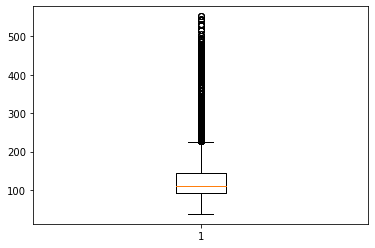

In [60]:
plt.boxplot(df['power'])# / diesel['engine_cap'])
plt.show()

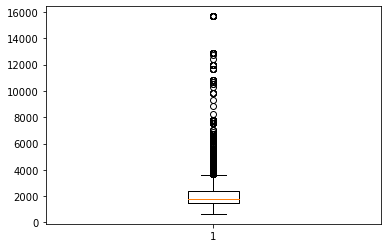

In [61]:
plt.boxplot(df['engine_cap'])# / diesel['engine_cap'])
plt.show()

plt.boxplot(df_[df_.fuel_type == 'petrol']['efficiency'])# / diesel['engine_cap']) ##outlier
plt.show()

# fill omv, get data with missing omv and dereg_value, fill in the omv
is_ = df[df.omv.isnull() & df.dereg_value.isnull()].index.tolist()
filled_omvs = []
for idx in is_:
    ag = df.at[idx, 'age']
    price = df.at[idx, 'price']
    mo = reg.predict(np.array([[ag, price]]))
    filled_omvs.append(mo)
for i, idx in enumerate(is_):
    df.at[idx, 'omv'] = filled_omvs[i]

In [62]:
print(df['coe'].isnull().sum())

1134


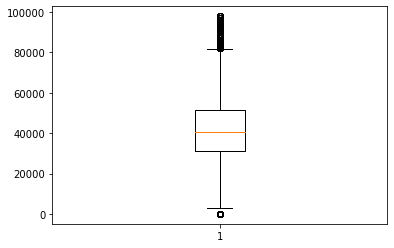

In [63]:
plt.boxplot(df['coe'].dropna())
plt.show()

In [70]:
# coe: fill in missing value for coe according to: age and power
fill_arf = df[df.arf.isnull()]
for idx, row in fill_arf.iterrows():
    omv = row['omv']
    if omv < 20000:
        df.at[idx, 'arf'] = omv
    elif omv >= 20000 and omv <= 50000:
        df.at[idx, 'arf'] = (omv - 20000) * 1.40 + 20000
    else:
        df.at[idx, 'arf'] =  (omv - 50000) * 1.80 + 62000
print(len(df[df.arf.isnull()]))
# df = df[~(df.arf.isnull() & df.dereg_value.isnull())] # remove values whose dereg_value cannot be calculated

0


In [71]:
# for date missing both coe and dereg_value, record it's month engine and power
coe_to_search = []
to_search = df[df.coe.isnull() & df.dereg_value.isnull()]

for idx, row in to_search.iterrows():
    # category -> A / B
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    coe_to_search.append((cat, month))

coe_to_search = list(set(coe_to_search))
print(len(coe_to_search))

33


In [72]:
t_to_coe = {}

for t in coe_to_search:
    t_to_coe[str(t)] = []

remains = df[~df.coe.isnull()]

for idx, row in remains.iterrows():
    if idx % 10000 == 0:
        print(idx)

    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    
    t = (cat, month)
    
    coe = row["coe"]
    if t in coe_to_search:
        t_to_coe[str(t)].append(coe)
        
c = 0
for idx, row in df.iterrows():
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    t = str((cat, month))

    if type(row["coe"]) == float and pd.isna(row["coe"]):
        if t in t_to_coe:
            l = t_to_coe[t]
            if len(l) > 0:
                avg = sum(l) / len(l)
                df.at[idx, 'coe'] = avg
                c += 1
print(c)

0
10000
1132


In [75]:
avg = np.average(df[df.coe.isnull()]['coe'])
df['coe'].fillna(avg)

0       75467.828746
1       10660.000000
2       53694.000000
3       40690.000000
4       26667.000000
            ...     
4995    36001.000000
4996    41001.000000
4997    72369.000000
4998    53334.000000
4999    49387.557576
Name: coe, Length: 21750, dtype: float64

In [76]:
import math
for idx, row in df.iterrows():
    if type(row["dereg_value"]) == float and pd.isna(row["dereg_value"]):
        max_age = 10 * 12
        age = row["age"]
        time_left = max_age - age
        coe = row["coe"]
        omv = row["omv"]
        arf = row["arf"]
        parf_ratio = 0
        if age <  5 * 12:
            parf_ratio = 0.75
        elif age >= 5 * 12 and age < 10 * 12:
            parf_ratio = 0.75 - math.ceil((age - 5 * 12) / 12) * 0.05 
        coe_rebate = coe * row['remaining_coe'] / 120
        dereg_value = parf_ratio * arf + coe_rebate
        if dereg_value <= 0:
            dereg_value = 0
        df.at[idx, "dereg_value"] = dereg_value

In [77]:
## train
df_train = df[:16784]
df_test = df[16784:]
df_train.to_csv('train_raw.csv')
df_test.to_csv('test_raw.csv')

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21750 entries, 0 to 4999
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         21750 non-null  int64  
 1   title              21750 non-null  object 
 2   make               21750 non-null  object 
 3   model              21750 non-null  object 
 4   description        21294 non-null  object 
 5   manufactured       21496 non-null  float64
 6   original_reg_date  414 non-null    object 
 7   reg_date           21489 non-null  object 
 8   type_of_vehicle    21750 non-null  object 
 9   category           21750 non-null  object 
 10  transmission       21750 non-null  object 
 11  curb_weight        21041 non-null  float64
 12  power              21750 non-null  float64
 13  fuel_type          4539 non-null   object 
 14  engine_cap         21750 non-null  float64
 15  no_of_owners       21519 non-null  float64
 16  depreciation       2118

In [79]:
df.dropna(subset=['depreciation'])

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,age,remaining_coe
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,45330.0,50462.0,NaN,NaN,uncategorized,"5 doors gt, powerful and fuel efficient 2.0l t...","bmw i-drive, navigation, bluetooth/aux/usb inp...",NaN,96,12
1,1021510,Toyota Hiace 3.0M,toyota,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,27502.0,1376.0,NaN,25-jan-2035,uncategorized,low mileage unit. well maintained vehicle. vie...,factory radio setting. front recording camera....,NaN,84,167
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,27886.0,26041.0,NaN,NaN,uncategorized,responsive and fuel efficient 1.6l inline 4 cy...,dual electric/memory seats. factory fitted aud...,NaN,60,53
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,46412.0,56977.0,NaN,NaN,uncategorized,"1.5l inline-4 twin scroll turbocharged engine,...",64 colour ambient lighting. active parking ass...,NaN,24,97
4,1031014,Honda Civic 1.6A VTi,honda,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,20072.0,20101.0,NaN,NaN,uncategorized,"1.6l i-vtec engine, 123 bhp, earth dreams cvt ...","s/rims, premium leather seats, factory touch s...",NaN,24,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1010230,Subaru Impreza 5D 1.6i-S,subaru,impreza,"full loan available, low-interest rates. super...",2017.0,NaN,29-sep-2017,hatchback,"parf car, consignment car",...,13452.0,13452.0,NaN,NaN,uncategorized,subaru's 1.6l 113bhp 150nm boxer engine! cvt a...,"sunroof, bt, apple carplay, android auto. keyl...",NaN,48,63
4996,1001823,Toyota Previa 2.4A Aeras Luxury Moonroof,mercedes-benz,previa,as good as new! owner's 4th car! full sheltere...,2019.0,NaN,31-oct-2019,mpv,"parf car, premium ad car, low mileage car",...,34487.0,40282.0,NaN,NaN,uncategorized,"2,362cc 4 cylinders inline 16 valve dohc with ...","navigation, bluetooth, keyless entry/start, el...",NaN,24,86
4997,1027276,BMW 3 Series 316i Sport,bmw,316i,32186,2013.0,NaN,17-jan-2014,luxury sedan,"parf car, low mileage car",...,35847.0,32186.0,NaN,NaN,uncategorized,"bmw 1.6l twinturbo engine at 134bhp, 8 speed z...","dual electric/memory sport seats, keyless entr...",NaN,96,35
4998,1019321,Honda HR-V 1.5A LX,honda,hr-v,special 12 mths engine warranty with 2 free se...,2016.0,NaN,20-sep-2016,suv,"parf car, low mileage car",...,23650.0,20110.0,NaN,NaN,uncategorized,"1.5l earth dreams engine, 128 bhp, cvt auto wi...","premium leather seats, 17"" sports rims, factor...",NaN,60,51


In [93]:
df['predicted_prices'] = df['power']
for idx, row in df.iterrows():
    age = row['age']
    parf = min(row['arf'], row['omv'])
    if age <= 96:
        parf = row['omv']
    parf *= 0.5
    cAge = row['remaining_coe'] / 12
    depreciation = row['depreciation']
    current_price = parf + depreciation * cAge
    df.at[idx, 'predicted_prices'] = current_price

In [94]:
old_train = pd.read_csv('train.csv')[['listing_id','price']]
res = pd.merge(df[:16784], old_train, left_on='listing_id', right_on='listing_id', how='inner')
res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16868 entries, 0 to 16867
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         16868 non-null  int64  
 1   title              16868 non-null  object 
 2   make               16868 non-null  object 
 3   model              16868 non-null  object 
 4   description        16523 non-null  object 
 5   manufactured       16675 non-null  float64
 6   original_reg_date  315 non-null    object 
 7   reg_date           16668 non-null  object 
 8   type_of_vehicle    16868 non-null  object 
 9   category           16868 non-null  object 
 10  transmission       16868 non-null  object 
 11  curb_weight        16309 non-null  float64
 12  power              16868 non-null  float64
 13  fuel_type          3522 non-null   object 
 14  engine_cap         16868 non-null  float64
 15  no_of_owners       16693 non-null  float64
 16  depreciation       164

In [95]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

res = res.dropna(subset=['predicted_prices', 'price'])
predictions = np.array(res['predicted_prices']).reshape(-1,1)
actual = res['price']

reg = LinearRegression().fit(predictions, actual)
print(reg.score(predictions, actual))

# mse=mean_squared_error(predictions, actual)
# print(mse)

0.2778692741720783


In [96]:
mse=mean_squared_error(predictions, actual)
print(mse)

11782656294.497316


In [170]:
# drop irrelevant
df = df.drop(columns = ['title', 'make', 'model', 'description', 'arf', 'original_reg_date','reg_date', 'opc_scheme', 'listing_id', 'indicative_price', 'manufactured', 'no_of_owners', 'lifespan', 'eco_category', 'accessories', 'depreciation', 'road_tax', 'features'])

In [171]:
df = df.drop(columns = ['curb_weight', 'fuel_type'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type_of_vehicle  5000 non-null   object 
 1   category         5000 non-null   object 
 2   transmission     5000 non-null   object 
 3   power            5000 non-null   float64
 4   engine_cap       5000 non-null   float64
 5   coe              5000 non-null   float64
 6   dereg_value      5000 non-null   float64
 7   mileage          5000 non-null   float64
 8   omv              5000 non-null   float64
 9   age              5000 non-null   int64  
 10  remaining_coe    5000 non-null   int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 429.8+ KB


In [172]:
cars_dummies = pd.get_dummies(df['type_of_vehicle'])
df = pd.concat([df, cars_dummies], axis=1)
cars_dummies = pd.get_dummies(df['transmission'])
df = pd.concat([df, cars_dummies], axis=1)
df = df.drop(columns = ['type_of_vehicle', 'category', 'transmission'])

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   power            5000 non-null   float64
 1   engine_cap       5000 non-null   float64
 2   coe              5000 non-null   float64
 3   dereg_value      5000 non-null   float64
 4   mileage          5000 non-null   float64
 5   omv              5000 non-null   float64
 6   age              5000 non-null   int64  
 7   remaining_coe    5000 non-null   int64  
 8   bus/mini bus     5000 non-null   uint8  
 9   hatchback        5000 non-null   uint8  
 10  luxury sedan     5000 non-null   uint8  
 11  mid-sized sedan  5000 non-null   uint8  
 12  mpv              5000 non-null   uint8  
 13  others           5000 non-null   uint8  
 14  sports car       5000 non-null   uint8  
 15  stationwagon     5000 non-null   uint8  
 16  suv              5000 non-null   uint8  
 17  truck         

In [174]:
df.to_csv('numerical_cleaned_test.csv')